In [32]:
push!(LOAD_PATH, "./")
using Plots
using Bspline
using FastGaussQuadrature
using LinearAlgebra
using WriteVTK

In [33]:
function INT2(f,a,b,nip) # 被積分関数f，区間[a,b]，積分点の個数nipを引数にとり，積分値を返す
    I = 0
    nodes,weights = gausslegendre(nip)
    for i in 1:nip
        I += f((b-a)/2*nodes[i]+(a+b)/2)*weights[i]
    end
    I *= (b-a)/2
    return I
end

INT2 (generic function with 1 method)

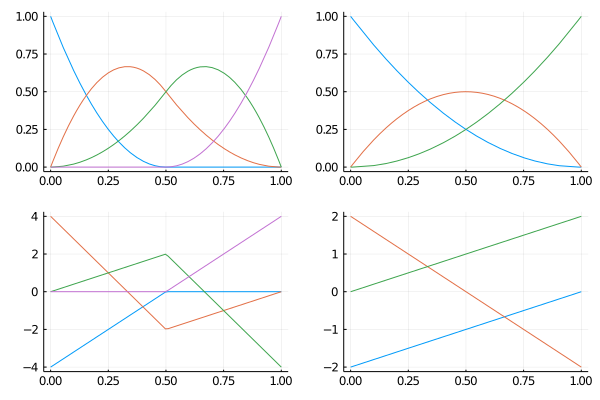

In [134]:
# B-spline関数のリファインメント
function pref(pi,p,k)    # pi:リファインメント前の次数, p:リファインメント後の次数
    l = k[1]
    r = k[end]
    n = p-pi
    prepend!(k,[l for i in 1:n])
    append!(k,[r for i in 1:n])
end
function href(p,k,N)    # N:リファインメント後の基底関数の個数
    for i in 1:N-p-1
        insert!(k,p+1+i,i/(N-p))
    end
end

# 初期の基底関数
p1i = 1
p2i = 1
k1i = [0.0, 0.0, 1.0, 1.0]
k2i = [0.0, 0.0, 1.0, 1.0]

# リファインメント後の基底関数
p1 = 2
p2 = 2
k1 = copy(k1i)
k2 = copy(k2i)
N1 = 4    # 1軸方向の基底関数の個数
N2 = 3    # 2軸方向の基底関数の個数
pref(p1i,p1,k1)
pref(p2i,p2,k2)
href(p1,k1,N1)
href(p2,k2,N2)
plot(
    plot([t->Bs(i,p1,k1,t) for i in 1:N1],0,1,legend=false),
    plot([t->Bs(i,p2,k2,t) for i in 1:N2],0,1,legend=false),
    plot([t->Ḃs(i,p1,k1,t) for i in 1:N1],0,1,legend=false),
    plot([t->Ḃs(i,p2,k2,t) for i in 1:N2],0,1,legend=false),
)

In [132]:
# 剛性行列
λ = 122.0e3
μ = 79.0e3
J1 = 10.0
J2 = 1.0
detJ = 1#10.0
nip = 2    # 積分点の数 (p1+1)/2以上
N = N1*N2    # 1,2軸方向の基底関数の組み合わせの数
K11 = zeros(Float64,(N,N))
K22 = zeros(Float64,(N,N))
K12 = zeros(Float64,(N,N))
K21 = zeros(Float64,(N,N))
for α in 1:N
    for β in 1:N
        α1 = div(α-1,N2)+1    # 1軸方向の基底関数の番号
        α2 = (α-1)%N2+1    # 2軸方向の基底関数の番号
        β1 = div(β-1,N2)+1    # 1軸方向の基底関数の番号
        β2 = (β-1)%N2+1    # 2軸方向の基底関数の番号
        
        c11_1 = sum(INT2(t->Ḃs(α1,p1,k1,t)*Ḃs(β1,p1,k1,t),k1[m],k1[m+1],nip) for m in 1:length(k1)-1)
        c11_2 = sum(INT2(t->Bs(α2,p2,k2,t)*Bs(β2,p2,k2,t),k2[m],k2[m+1],nip) for m in 1:length(k2)-1)
        c11_3 = sum(INT2(t->Bs(α1,p1,k1,t)*Bs(β1,p1,k1,t),k1[m],k1[m+1],nip) for m in 1:length(k1)-1)
        c11_4 = sum(INT2(t->Ḃs(α2,p2,k2,t)*Ḃs(β2,p2,k2,t),k2[m],k2[m+1],nip) for m in 1:length(k2)-1)
        K11[α,β] = (λ+2μ)/(J1^2)*c11_1*c11_2*detJ + μ/(J2^2)*c11_3*c11_4*detJ
        
        c22_1 = sum(INT2(t->Bs(α1,p1,k1,t)*Bs(β1,p1,k1,t),k1[m],k1[m+1],nip) for m in 1:length(k1)-1)
        c22_2 = sum(INT2(t->Ḃs(α2,p2,k2,t)*Ḃs(β2,p2,k2,t),k2[m],k2[m+1],nip) for m in 1:length(k2)-1)
        c22_3 = sum(INT2(t->Ḃs(α1,p1,k1,t)*Ḃs(β1,p1,k1,t),k1[m],k1[m+1],nip) for m in 1:length(k1)-1)
        c22_4 = sum(INT2(t->Bs(α2,p2,k2,t)*Bs(β2,p2,k2,t),k2[m],k2[m+1],nip) for m in 1:length(k2)-1)
        K22[α,β] = (λ+2μ)/(J2^2)*c22_1*c22_2*detJ + μ/(J1^2)*c22_3*c22_4*detJ 
        
        c12_1 = sum(INT2(t->Ḃs(α1,p1,k1,t)*Bs(β1,p1,k1,t),k1[m],k1[m+1],nip) for m in 1:length(k1)-1)
        c12_2 = sum(INT2(t->Bs(α2,p2,k2,t)*Ḃs(β2,p2,k2,t),k2[m],k2[m+1],nip) for m in 1:length(k2)-1)
        c12_3 = sum(INT2(t->Bs(α1,p1,k1,t)*Ḃs(β1,p1,k1,t),k1[m],k1[m+1],nip) for m in 1:length(k1)-1)
        c12_4 = sum(INT2(t->Ḃs(α2,p2,k2,t)*Bs(β2,p2,k2,t),k2[m],k2[m+1],nip) for m in 1:length(k2)-1)
        K12[α,β] = λ/(J1*J2)*c12_1*c12_2*detJ + μ/(J1*J2)*c12_3*c12_4*detJ
        
        c21_1 = sum(INT2(t->Bs(α1,p1,k1,t)*Ḃs(β1,p1,k1,t),k1[m],k1[m+1],nip) for m in 1:length(k1)-1)
        c21_2 = sum(INT2(t->Ḃs(α2,p2,k2,t)*Bs(β2,p2,k2,t),k2[m],k2[m+1],nip) for m in 1:length(k2)-1)
        c21_3 = sum(INT2(t->Ḃs(α1,p1,k1,t)*Bs(β1,p1,k1,t),k1[m],k1[m+1],nip) for m in 1:length(k1)-1)
        c21_4 = sum(INT2(t->Bs(α2,p2,k2,t)*Ḃs(β2,p2,k2,t),k2[m],k2[m+1],nip) for m in 1:length(k2)-1)
        K21[α,β] = λ/(J1*J2)*c21_1*c21_2*detJ + μ/(J1*J2)*c21_3*c21_4*detJ
    end
end

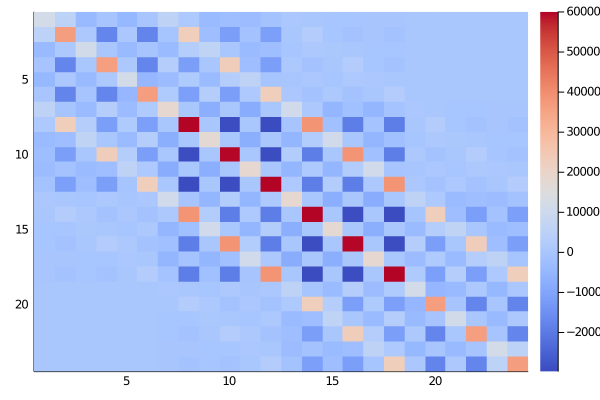

In [133]:
K = zeros(Float64,(2N,2N))
for i in 1:2N
    for j in 1:2N
        α = div(i-1,2)+1
        β = div(j-1,2)+1
        αflag = (i-1)%2+1
        βflag = (j-1)%2+1
        if αflag==1 && βflag==1
            K[i,j] = K11[α,β]
        elseif αflag==2 && βflag==2
            K[i,j] = K22[α,β]
        elseif αflag==1 && βflag==2
            K[i,j] = K12[α,β]
        elseif αflag==2 && βflag==1
            K[i,j] = K21[α,β]
        end
    end
end
heatmap(K,yflip=true,color=:coolwarm)

In [118]:
rank(K)

45

In [119]:
eigvals(K)

48-element Array{Float64,1}:
     -1.8121952629088608e-11
     -5.761764241910447e-12
      2.236327361976174e-11
     21.02225754289771
    130.35513254906004
    316.4158399917319
    556.4390091673457
    632.5833526122425
   2251.5911687903094
   2868.4328815599683
   3673.554802036071
   4203.421671000701
   4629.626862126126
      ⋮
  59619.123672137626
  62095.240174515944
  68219.12853480973
  81861.93653908245
  83356.79139811368
  89925.88765305349
  91941.8375457106
 120358.68252784063
 155809.72369877744
 208163.817618441
 241330.47537746635
 321944.567245092

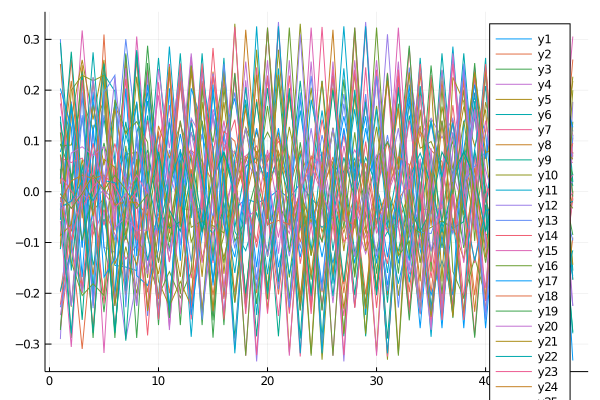

In [120]:
eigvecK = copy(eigvecs(K))
plot(eigvecK)

In [121]:
# 右辺ベクトル
g = [0.0, -10.0]
detJsurface = 1.0 # 右端(1次元)の座標変換なので、Jsurface = 1となり行列式も1となる
b = zeros(Float64,2N)
for idx in 1:2N
    β = div(idx-1,2)+1
    i = (idx-1)%2+1    # 軸方向
    β1 = div(β-1,N2)+1    # 1軸方向の基底関数の番号
    β2 = (β-1)%N2+1    # 2軸方向の基底関数の番号
    b[idx] = sum(INT2(t->g[i]*Bs(β1,p1,k1,1.0)*Bs(β2,p2,k2,t)*detJsurface,k2[m],k2[m+1],nip) for m in 1:length(k2)-1)
end
b

48-element Array{Float64,1}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
 -1.6666666666666667
  0.0
 -3.3333333333333335
  0.0
 -3.333333333333333
  0.0
 -1.6666666666666667

In [122]:
# Dirichlet境界条件を負荷
# 右辺ベクトル
U = [0.0, 0.0]    # Dirichlet境界条件の変位
for idx in 1:2N2
    i = (idx-1)%2+1
    b[idx] = U[i]
end
for idx in 2N2+1:2N
    i = (idx-1)%2+1
    b[idx] = b[idx]-K[idx,1]*U[i]
end

# 剛性行列
K[1:2N2,:] .= 0.0
K[:,1:2N2] .= 0.0
for i in 1:2N2
    K[i,i] = 1.0
end
K

48×48 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …       0.0        0.0         0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0          0.0        0.0         0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0          0.0        0.0         0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0          0.0        0.0         0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0          0.0        0.0         0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …       0.0        0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0          0.0        0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0          0.0        0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0          0.0        0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0          0.0        0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …       0.0        0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0          0.0        0.0         0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0          0.0        0.0 

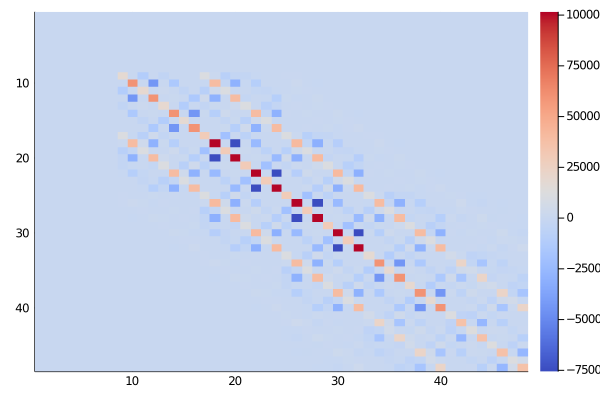

In [126]:
heatmap(K,yflip=true,color=:coolwarm)

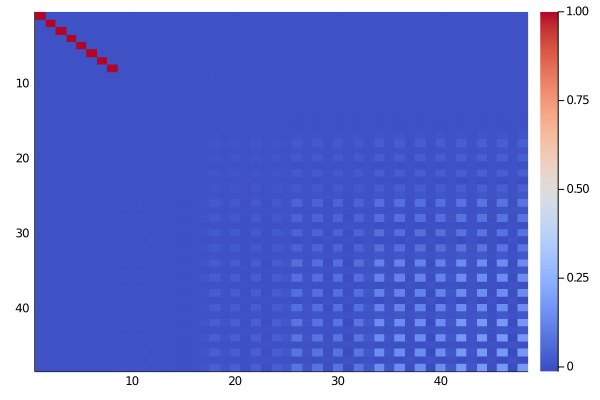

In [123]:
heatmap(inv(K),yflip=true,color=:coolwarm)

In [124]:
# 連立方程式を解く
uc = zeros(Float64,2N)
uc = K\b    # 変位の係数
uc1 = [uc[2i-1] for i in 1:N]    # 1軸方向の変位の係数
uc2 = [uc[2i] for i in 1:N]    # 2軸方向の変位の係数
uc1

24-element Array{Float64,1}:
  0.0
  0.0
  0.0
  0.0
 -0.030313470690089928
 -0.014482491842488244
  0.01448249184248816
  0.030313470690089828
 -0.08117760156497623
 -0.040698869612001316
  0.040698869612001025
  0.08117760156497593
 -0.11404183978938685
 -0.056593564120786505
  0.05659356412078562
  0.11404183978938613
 -0.13049712611934192
 -0.06526306692020505
  0.06526306692020413
  0.13049712611934067
 -0.1306667369244879
 -0.06497124100596306
  0.06497124100596287
  0.13066673692448835

In [80]:
# 変位を求める
t1l = 100
t2l = 10
t1 = collect(range(1.0e-10,stop=1.0-1.0e-10, length=t1l))
t2 = collect(range(1.0e-10,stop=1.0-1.0e-10, length=t2l))
x1 = collect(range(1.0e-10,stop=10.0-1.0e-10, length=t1l))
x2 = collect(range(1.0e-10,stop=1.0-1.0e-10, length=t2l))
u = zeros(Float64,(2,t1l,t2l))
for i in 1:t1l    # 1軸方向の番号
    for j in 1:t2l    # 2軸方向の番号
        # ↓ N2*(α-1)+β は 1~N(=1~36) を動く
        u[1,i,j] = sum(Bs(α,p1,k1,t1[i])*Bs(β,p2,k2,t2[j])*uc1[N2*(α-1)+β] for α in 1:N1, β in 1:N2)
        u[2,i,j] = sum(Bs(α,p1,k1,t1[i])*Bs(β,p2,k2,t2[j])*uc2[N2*(α-1)+β] for α in 1:N1, β in 1:N2)
    end
end
u[2,:,:]

100×10 Array{Float64,2}:
 -4.63096e-12  -4.57405e-12  -4.53136e-12  …  -4.57405e-12  -4.63096e-12
 -0.00048115   -0.000475471  -0.000471211     -0.000475471  -0.00048115
 -0.000989051  -0.000977832  -0.000969419     -0.000977832  -0.000989051
 -0.0015237    -0.00150709   -0.00149462      -0.00150709   -0.0015237
 -0.00208511   -0.00206323   -0.00204682      -0.00206323   -0.00208511
 -0.00267327   -0.00264627   -0.00262601   …  -0.00264627   -0.00267327
 -0.00328818   -0.00325619   -0.0032322       -0.00325619   -0.00328818
 -0.00392984   -0.00389301   -0.00386539      -0.00389301   -0.00392984
 -0.00459825   -0.00455672   -0.00452557      -0.00455672   -0.00459825
 -0.00529341   -0.00524732   -0.00521275      -0.00524732   -0.00529341
 -0.00601533   -0.00596481   -0.00592692   …  -0.00596481   -0.00601533
 -0.006764     -0.0067092    -0.00666809      -0.0067092    -0.006764
 -0.00753942   -0.00748047   -0.00743626      -0.00748047   -0.00753942
  ⋮                                     

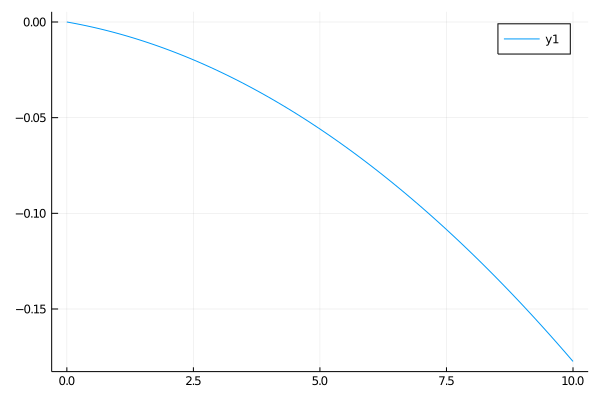

In [81]:
plot(x1,u[2,:,1])

In [82]:
u̇ = zeros(Float64,(2,2,t1l,t2l))    # ∂u∂x[軸方向, 軸方向, 1軸の評価点, 2軸の評価点]
for i in 1:t1l    # 1軸方向の番号
    for j in 1:t2l    # 2軸方向の番号
        for α in 1:N
            α1 = div(α-1,N2)+1    # 1軸方向の基底関数の番号
            α2 = (α-1)%N2+1    # 2軸方向の基底関数の番号
            u̇[1,1,i,j] += Ḃs(α1,p1,k1,t1[i])*Bs(α2,p2,k2,t2[j])/J1*uc1[α]
            u̇[1,2,i,j] += Bs(α1,p1,k1,t1[i])*Ḃs(α2,p2,k2,t2[j])/J2*uc2[α]
            u̇[2,1,i,j] += Ḃs(α1,p1,k1,t1[i])*Bs(α2,p2,k2,t2[j])/J1*uc1[α]
            u̇[2,2,i,j] += Bs(α1,p1,k1,t1[i])*Ḃs(α2,p2,k2,t2[j])/J2*uc2[α]
        end
    end
end

# ひずみ    ϵ[軸方向, 軸方向, 1軸の評価点, 2軸の評価点]
ϵ = zeros(Float64,(2,2,t1l,t2l))
for k in 1:t1l    # 1軸方向の番号
    for l in 1:t2l    # 2軸方向の番号
        for i in 1:2
            for j in 1:2
                ϵ[i,j,k,l] = (1.0/2.0)*(u̇[i,j,k,l]*u̇[j,i,k,l])
            end
        end
    end
end

# 応力
σ = zeros(Float64,(2,2,t1l,t2l))
for k in 1:t1l    # 1軸方向の番号
    for l in 1:t2l    # 2軸方向の番号
        for i in 1:2
            for j in 1:2
                if i==j
                    σ[i,j,k,l] = λ*(ϵ[1,1,k,l]+ϵ[2,2,k,l])+2μ*ϵ[i,j,k,l]
                else
                    σ[i,j,k,l] = 2μ*ϵ[i,j,k,l]
                end
            end
        end
    end
end

In [83]:
# vtkファイルを作成
# 物体の形状データを読み込ませる
vtkfile = vtk_grid("2diga", x1, x2)  # 第一引数にx方向の物理空間上の評価点、第２引数にy方向の評価点（いずれも1次元配列）

# 得られた変位のデータを読み込ませる
vtk_point_data(vtkfile, u, "displacement")    # displacement[次元，x方向の評価点の番号，y方向の評価点の番号]
vtk_point_data(vtkfile, ϵ[1,1,:,:], "Strain11")
vtk_point_data(vtkfile, ϵ[2,2,:,:], "Strain22")

# ファイルの吐き出し
outfiles = vtk_save(vtkfile)

1-element Array{String,1}:
 "2diga.vtr"

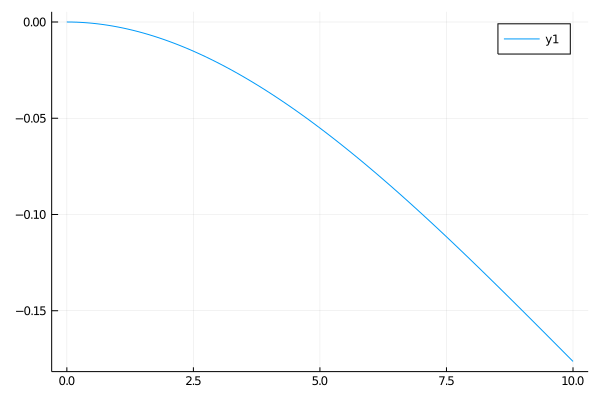

In [84]:
# 厳密解
W = 10.0
I = 1.0/12.0
L1 = 10.0

Es = μ*(3λ+2μ)/(λ+μ)
ν = λ/(2*(λ+μ))
En = Es/(1-ν^2)

xl = 100
x = collect(range(1.0e-10,stop=10.0-1.0e-10,length=xl))
y = zeros(Float64,xl)
for i in 1:xl
    y[i] = W/(En*I)*(x[i]^3/6.0-L1*x[i]^2/2.0)
end
plot(x,y)

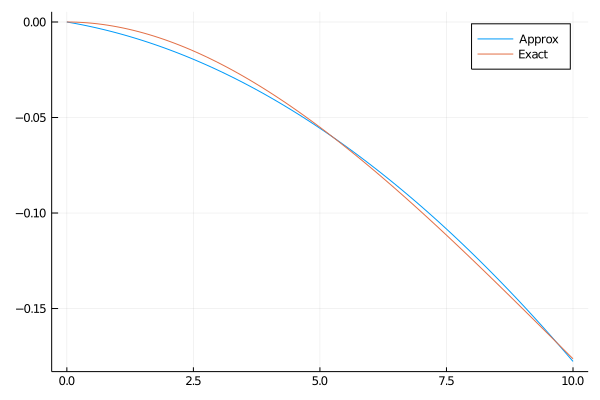

In [85]:
plot(x,u[2,:,5],label="Approx")
plot!(x,y,label="Exact")